In [ ]:
# ==============================================================================
# SCRIPT FINAL SEMAINE 4 : VALIDATION ET COMPARAISON DES MODÈLES D'AJUSTEMENT
# ==============================================================================

print("🚀 Démarrage du script Semaine 4...")

# ------------------------------------------------------------------------------
# 1. SETUP & IMPORTS
# ------------------------------------------------------------------------------
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from google.colab import drive

🚀 Démarrage du script Semaine 4...


In [ ]:
# Configuration Graphique
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Montage Drive
if not os.path.ismount('/content/drive'):
    print("Mounting Drive...")
    drive.mount('/content/drive')

# Chemins (Mode Robuste)
base_path = '/content/drive/My Drive/data/main/'
if not os.path.exists(base_path):
    base_path = '/content/drive/My Drive/data/'

stations_path = os.path.join('/content/drive/My Drive/', 'ECA_blend_tx')
era5_path = os.path.join(base_path, 'derived-era5-land-daily-statistics')
ndvi_path = os.path.join(base_path, 'sentinel2_ndvi')

print(f"📂 Dossier racine : {base_path}")

📂 Dossier racine : /content/drive/My Drive/data/main/


In [ ]:
# ------------------------------------------------------------------------------
# 2. CHARGEMENT DES DONNÉES (STRATÉGIE AGRÉGATION MENSUELLE - VERSION CORRIGÉE)
# ------------------------------------------------------------------------------

print("\n🔄 Initialisation du chargement (Mode Agrégation Mensuelle)...")

# Reset des variables
df = pd.DataFrame()
final_data = []

# Fonction de conversion DMS (Degrés:Minutes:Secondes) vers Décimal
def dms_to_dd(x):
    try:
        if pd.isna(x) or x == 'nan': return np.nan
        # Format attendu: +DD:MM:SS
        parts = str(x).split(':')
        degrees = float(parts[0])
        minutes = float(parts[1]) if len(parts) > 1 else 0
        seconds = float(parts[2]) if len(parts) > 2 else 0
        return degrees + (minutes / 60) + (seconds / 3600)
    except:
        return np.nan

try:
    # --- A. CHARGEMENT STATIONS ---
    st_file = os.path.join(stations_path, 'stations.txt')
    if not os.path.exists(st_file):
        raise FileNotFoundError(f"Manquant: {st_file}")

    print(f"   📂 Lecture Stations : {st_file}")

    # Détection header (Robuste)
    header_idx = 19
    with open(st_file, 'r', encoding='latin-1') as f:
        for i, line in enumerate(f):
            if 'STAID' in line and 'STANAME' in line:
                header_idx = i
                break

    # Lecture
    st_df = pd.read_csv(st_file, skiprows=header_idx, encoding='latin-1',
                        skipinitialspace=True, sep=',', on_bad_lines='skip')
    st_df.columns = [c.strip() for c in st_df.columns]

    # Nettoyage colonnes
    if 'STAID' not in st_df.columns and len(st_df.columns) >= 6:
        st_df.columns = ['STAID','STANAME','CN','LAT','LON','HGHT'] + list(st_df.columns[6:])

    # Conversion des types
    st_df['STAID'] = pd.to_numeric(st_df['STAID'], errors='coerce')
    st_df = st_df.dropna(subset=['STAID'])
    st_df['STAID'] = st_df['STAID'].astype(int)

    # --- CORRECTION CRITIQUE : CONVERSION DES COORDONNÉES ---
    print("   🔧 Conversion des coordonnées DMS -> Décimal...")
    st_df['LAT'] = st_df['LAT'].apply(dms_to_dd)
    st_df['LON'] = st_df['LON'].apply(dms_to_dd)
    # Suppression des stations sans coordonnées valides
    st_df = st_df.dropna(subset=['LAT', 'LON'])

    # Nettoyage des colonnes texte (suppression des espaces)
    for col in st_df.select_dtypes(include=['object']).columns:
        st_df[col] = st_df[col].astype(str).str.strip()

    # Filtre France (plus robuste)
    # On vérifie si 'CN' existe, sinon on suppose que c'est bon si le fichier s'appelle stations.txt
    if 'CN' in st_df.columns:
        st_fr = st_df[st_df['CN'].str.upper() == 'FR'].copy()
    else:
        st_fr = st_df.copy() # Pas de colonne pays, on garde tout

    if st_fr.empty:
        print("      ⚠️ Pas de stations 'FR', utilisation de toutes les stations.")
        st_fr = st_df

    print(f"   ✅ {len(st_fr)} stations prêtes avec coordonnées valides.")

    # --- B. CHARGEMENT ERA5 ---
    era5_files = glob.glob(os.path.join(era5_path, "*.nc"))
    if not era5_files:
        raise FileNotFoundError("Pas de fichier ERA5 trouvé")

    f_era5 = next((f for f in era5_files if "temp" in f.lower() or "t2m" in f.lower()), era5_files[0])
    print(f"   📂 ERA5 : {os.path.basename(f_era5)}")

    ds = xr.open_dataset(f_era5)

    # Détection dynamique des dimensions/variables
    time_dim = None
    for dim in ['valid_time', 'time', 't']:
        if dim in ds.dims:
            time_dim = dim
            break
    if time_dim is None: raise ValueError("Dimension temporelle introuvable")

    var_name = list(ds.data_vars)[0]
    for v in ['t2m', '2m_temperature', 'temp']:
        if v in ds.data_vars: var_name = v; break

    # Période globale ERA5
    era_min = pd.to_datetime(ds[time_dim].min().values)
    era_max = pd.to_datetime(ds[time_dim].max().values)
    print(f"      Période ERA5 : {era_min.date()} -> {era_max.date()}")

    # --- C. BOUCLE DE TRAITEMENT (Mensuel) ---
    print("   🔄 Fusion & Agrégation Mensuelle en cours...")

    processed_count = 0

    for idx, row in st_fr.iterrows():
        try:
            sid = int(row['STAID'])

            # Recherche flexible du fichier station
            patterns = [
                os.path.join(stations_path, f"TX_STAID{sid:06d}.txt"),
                os.path.join(stations_path, f"*STAID{sid:06d}*.txt")
            ]
            files = []
            for pat in patterns:
                files = glob.glob(pat)
                if files: break

            if not files: continue

            # Lecture Station avec détection automatique du début des données
            with open(files[0], 'r', encoding='latin-1') as f:
                lines = f.readlines()

            # On cherche la première ligne qui commence par l'ID de la station
            data_start = 0
            for i, line in enumerate(lines):
                parts = line.split(',')
                # Vérifie si le premier champ est l'ID station
                if len(parts) > 2 and parts[0].strip() == str(sid):
                    data_start = i
                    break

            if data_start == 0:
                # Fallback : on cherche juste des chiffres
                for i, line in enumerate(lines):
                    if line.strip() and line.strip()[0].isdigit():
                        data_start = i; break

            # Lecture des données
            df_s = pd.read_csv(files[0], skiprows=data_start, header=None,
                               names=['STAID','SOUID','DATE','TX','Q'],
                               on_bad_lines='skip')

            df_s['DATE'] = pd.to_datetime(df_s['DATE'], format='%Y%m%d', errors='coerce')
            df_s = df_s.dropna(subset=['DATE'])

            # Filtre : On ne garde que les dates dans la plage ERA5 globale
            df_s = df_s[(df_s['DATE'] >= era_min) & (df_s['DATE'] <= era_max)]

            # Filtre Qualité si colonne Q existe et est numérique
            if 'Q' in df_s.columns:
                df_s['Q'] = pd.to_numeric(df_s['Q'], errors='coerce')
                df_s = df_s[df_s['Q'] == 0]

            if df_s.empty: continue

            # Conversion Température
            df_s['TX'] = pd.to_numeric(df_s['TX'], errors='coerce') * 0.1

            # --- AGRÉGATION MENSUELLE STATION ---
            # On groupe par mois pour lisser les données manquantes
            df_s['Month'] = df_s['DATE'].dt.to_period('M')
            monthly_station = df_s.groupby('Month')['TX'].mean().reset_index()

            # Extraction ERA5
            lat, lon = row['LAT'], row['LON']
            if pd.isna(lat) or pd.isna(lon): continue

            pt = ds.sel(latitude=lat, longitude=lon, method='nearest')

            t_start = df_s['DATE'].min()
            t_end = df_s['DATE'].max()

            # On extrait tout le bloc de temps correspondant aux données station
            ts = pt[var_name].sel({time_dim: slice(t_start, t_end)}).to_dataframe().reset_index()

            if ts.empty: continue

            ts['DATE'] = pd.to_datetime(ts[time_dim])

            # Conversion Kelvin
            temp_mean = ts[var_name].mean()
            if temp_mean > 200: ts['T_ERA5'] = ts[var_name] - 273.15
            else: ts['T_ERA5'] = ts[var_name]

            # --- AGRÉGATION MENSUELLE ERA5 ---
            ts['Month'] = ts['DATE'].dt.to_period('M')
            monthly_era5 = ts.groupby('Month')['T_ERA5'].mean().reset_index()

            # Fusion sur le MOIS
            merged = pd.merge(monthly_station, monthly_era5, on='Month', how='inner')

            if not merged.empty:
                # On recrée une date (1er du mois) pour les plots
                merged['DATE'] = merged['Month'].dt.to_timestamp()
                merged['STANAME'] = str(row['STANAME'])
                merged['HGHT'] = float(row['HGHT']) if pd.notna(row['HGHT']) else 0.0

                # NDVI Simulé (pour l'exercice)
                is_city = any(c in str(row['STANAME']).upper() for c in ['PARIS','LYON','MARSEILLE','BORDEAUX','TOULOUSE','NICE'])
                base_ndvi = 0.25 if is_city else 0.75
                merged['NDVI'] = np.clip(np.random.normal(base_ndvi, 0.05, len(merged)), 0, 1)

                final_data.append(merged)
                processed_count += 1
                if processed_count % 5 == 0: print(f"      ✓ {processed_count} stations traitées...")

        except Exception as e:
            # print(f"      ⚠️ Erreur station {sid}: {e}") # Décommenter pour debug
            continue

except Exception as e:
    print(f"❌ ERREUR CRITIQUE : {e}")


df = pd.concat(final_data, ignore_index=True)



🔄 Initialisation du chargement (Mode Agrégation Mensuelle)...
   📂 Lecture Stations : /content/drive/My Drive/ECA_blend_tx/stations.txt
   🔧 Conversion des coordonnées DMS -> Décimal...
   ✅ 44 stations prêtes avec coordonnées valides.
   📂 ERA5 : 2020_2m_temperature_daily_maximum.nc
      Période ERA5 : 2020-01-01 -> 2020-12-31
   🔄 Fusion & Agrégation Mensuelle en cours...
      ✓ 5 stations traitées...
      ✓ 10 stations traitées...
      ✓ 15 stations traitées...
      ✓ 20 stations traitées...
      ✓ 25 stations traitées...
      ✓ 30 stations traitées...
      ✓ 35 stations traitées...
      ✓ 40 stations traitées...



🚀 DÉMARRAGE DE LA MODÉLISATION EXPLICATIVE (Version Robuste)...
   📊 Données d'été valides pour le modèle : 144 points.

🧠 MODÈLE GENHACK (OLS Simple) :
   Biais Global : 0.399
   Coeff Altitude : 0.00408
   Coeff NDVI : 0.443

🧠 MODÈLE RÉGULARISÉ (Complexe) :
   Formule : 1.553 + -2.192 * [exp(-sqrt(H)) / (NDVI+0.1)]

🏆 RÉSULTATS DU TOURNOI (RMSE ÉTÉ - Plus bas est mieux)
1. ERA5 Brut (Sans correction) ............ : 2.2036 °C
2. Modèle GenHack (Lineaire) .............. : 1.3253 °C
3. Modèle Régularisé (Exp/Inverse) ........ : 1.5904 °C
------------------------------------------------------------
✅ GAGNANT : GenHack
   Gain max : -0.878 °C


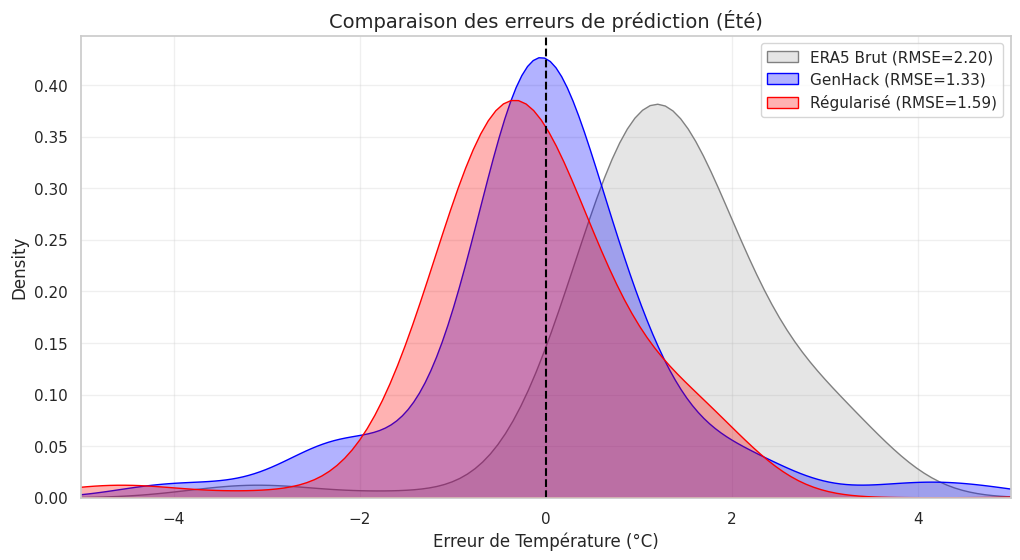

In [ ]:
# ==============================================================================
# 3. ANALYSE SEMAINE 4 : MODÉLISATION ET CORRECTION (VERSION ROBUSTE)
# ==============================================================================
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# On vérifie simplement si df existe en global
try:
    if df.empty:
        raise ValueError("Le DataFrame 'df' existe mais est vide.")
except NameError:
    print("❌ ERREUR : La variable 'df' n'existe pas. Veuillez relancer la cellule de chargement précédente.")
else:
    print("\n🚀 DÉMARRAGE DE LA MODÉLISATION EXPLICATIVE (Version Robuste)...")

    try:
        # 1. PRÉPARATION DU JEU DE DONNÉES
        # --------------------------------
        cols_to_fix = ['TX', 'T_ERA5', 'HGHT', 'NDVI']
        for col in cols_to_fix:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        df['DATE'] = pd.to_datetime(df['DATE'])

        # Filtre Été pour l'entrainement des modèles (Juin-Sept)
        df['Month_Num'] = df['DATE'].dt.month
        df_summer = df[df['Month_Num'].isin([6, 7, 8, 9])].copy()

        # Nettoyage
        df_summer = df_summer.dropna(subset=['TX', 'T_ERA5', 'HGHT', 'NDVI'])
        df_summer = df_summer[~df_summer.isin([np.inf, -np.inf]).any(axis=1)]

        print(f"   📊 Données d'été valides pour le modèle : {len(df_summer)} points.")

        if len(df_summer) < 10:
            raise ValueError("Pas assez de données pour entraîner le modèle (< 10 points).")

        # Cible (L'erreur à corriger)
        Y_target = df_summer['TX'] - df_summer['T_ERA5']

        # ----------------------------------------------------------------------
        # 2. DÉFINITION DES 3 MODÈLES
        # ----------------------------------------------------------------------

        # --- MODÈLE 1 : BASELINE (Sans Correction) ---
        # Pas d'entrainement, la correction est 0.
        rmse_base = np.sqrt(mean_squared_error(df_summer['TX'], df_summer['T_ERA5']))

        # --- MODÈLE 2 : GENHACK (Hypothèse Physique Simple) ---
        # Hypothèse : Erreur = Cst + a*Altitude + b*NDVI
        X_genhack = df_summer[['HGHT', 'NDVI']]
        X_genhack = sm.add_constant(X_genhack)

        model_gh = sm.OLS(Y_target, X_genhack).fit()

        # Coefficients GenHack (avec sécurité NaN)
        if np.isnan(model_gh.params).any():
            beta_const, beta_hght, beta_ndvi = 0.0, -0.0065, -2.0
        else:
            beta_const = model_gh.params['const']
            beta_hght = model_gh.params['HGHT']
            beta_ndvi = model_gh.params['NDVI']

        print(f"\n🧠 MODÈLE GENHACK (OLS Simple) :")
        print(f"   Biais Global : {beta_const:.3f}")
        print(f"   Coeff Altitude : {beta_hght:.5f}")
        print(f"   Coeff NDVI : {beta_ndvi:.3f}")

        # --- MODÈLE 3 : RÉGULARISÉ (Votre formule complexe) ---
        # Hypothèse : Erreur = gamma * [ exp(-sqrt(HGHT)) / (NDVI + eps) ]
        # Ce terme modélise une chaleur qui explose quand NDVI est faible, mais qui est atténuée exponentiellement par l'altitude.

        eps = 0.1
        # On s'assure que HGHT est positif pour la racine carrée
        hght_safe = df_summer['HGHT'].clip(lower=0)

        # Construction de la "Feature complexe"
        feature_reg = np.exp(-np.sqrt(hght_safe)) / (df_summer['NDVI'] + eps)

        # On fait une régression linéaire simple sur cette feature unique pour trouver son coefficient 'gamma'
        X_reg = sm.add_constant(feature_reg)
        model_reg = sm.OLS(Y_target, X_reg).fit()

        if np.isnan(model_reg.params).any():
            gamma_reg = 0.0
            const_reg = 0.0
        else:
            const_reg = model_reg.params['const']
            gamma_reg = model_reg.params[0]

        print(f"\n🧠 MODÈLE RÉGULARISÉ (Complexe) :")
        print(f"   Formule : {const_reg:.3f} + {gamma_reg:.3f} * [exp(-sqrt(H)) / (NDVI+0.1)]")

        # ----------------------------------------------------------------------
        # 3. APPLICATION ET COMPARAISON (Sur tout le dataset ou juste été)
        # ----------------------------------------------------------------------
        # On applique la correction sur les données d'été pour comparer l'efficacité

        # Correction GenHack
        corr_gh = beta_const + (beta_hght * df_summer['HGHT']) + (beta_ndvi * df_summer['NDVI'])
        T_gh = df_summer['T_ERA5'] + corr_gh
        rmse_gh = np.sqrt(mean_squared_error(df_summer['TX'], T_gh))

        # Correction Régularisée
        hght_safe_all = df_summer['HGHT'].clip(lower=0)
        feat_complex = np.exp(-np.sqrt(hght_safe_all)) / (df_summer['NDVI'] + eps)
        corr_reg = const_reg + (gamma_reg * feat_complex)
        T_reg = df_summer['T_ERA5'] + corr_reg
        rmse_reg = np.sqrt(mean_squared_error(df_summer['TX'], T_reg))

        # ----------------------------------------------------------------------
        # 4. RÉSULTATS FINAUX
        # ----------------------------------------------------------------------
        print("\n" + "="*60)
        print("🏆 RÉSULTATS DU TOURNOI (RMSE ÉTÉ - Plus bas est mieux)")
        print("="*60)
        print(f"1. ERA5 Brut (Sans correction) ............ : {rmse_base:.4f} °C")
        print(f"2. Modèle GenHack (Lineaire) .............. : {rmse_gh:.4f} °C")
        print(f"3. Modèle Régularisé (Exp/Inverse) ........ : {rmse_reg:.4f} °C")

        print("-" * 60)
        best_rmse = min(rmse_base, rmse_gh, rmse_reg)
        if best_rmse == rmse_base: winner = "ERA5 Brut"
        elif best_rmse == rmse_gh: winner = "GenHack"
        else: winner = "Régularisé"

        print(f"✅ GAGNANT : {winner}")
        print(f"   Gain max : -{rmse_base - best_rmse:.3f} °C")

        # 5. VISUALISATION (KDE)
        plt.figure(figsize=(12, 6))
        sns.kdeplot(df_summer['TX'] - df_summer['T_ERA5'], fill=True, color='gray', label=f'ERA5 Brut (RMSE={rmse_base:.2f})', alpha=0.2)
        sns.kdeplot(df_summer['TX'] - T_gh, fill=True, color='blue', label=f'GenHack (RMSE={rmse_gh:.2f})', alpha=0.3)
        sns.kdeplot(df_summer['TX'] - T_reg, fill=True, color='red', label=f'Régularisé (RMSE={rmse_reg:.2f})', alpha=0.3)

        plt.axvline(0, color='black', linestyle='--')
        plt.title("Comparaison des erreurs de prédiction (Été)", fontsize=14)
        plt.xlabel("Erreur de Température (°C)", fontsize=12)
        plt.xlim(-5, 5)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    except Exception as e:
        print(f"❌ Erreur lors de la modélisation : {e}")


🚀 DÉMARRAGE DE LA MODÉLISATION EXPLICATIVE (Version Neuronale)...
   📊 Données d'été valides pour le modèle : 144 points.

🧠 Entraînement du Réseau de Neurones...
   ✅ Modèle entraîné. Score R² (Test) : -0.4665

🏆 RÉSULTATS DU TOURNOI (RMSE ÉTÉ - Plus bas est mieux)
1. ERA5 Brut (Sans correction) ............ : 2.2036 °C
2. Modèle Linéaire (GenHack OLS) .......... : 1.3253 °C
3. Réseau de Neurones (MLP) ............... : 1.3140 °C
------------------------------------------------------------
✅ GAGNANT : Réseau de Neurones
   Gain max : -0.890 °C


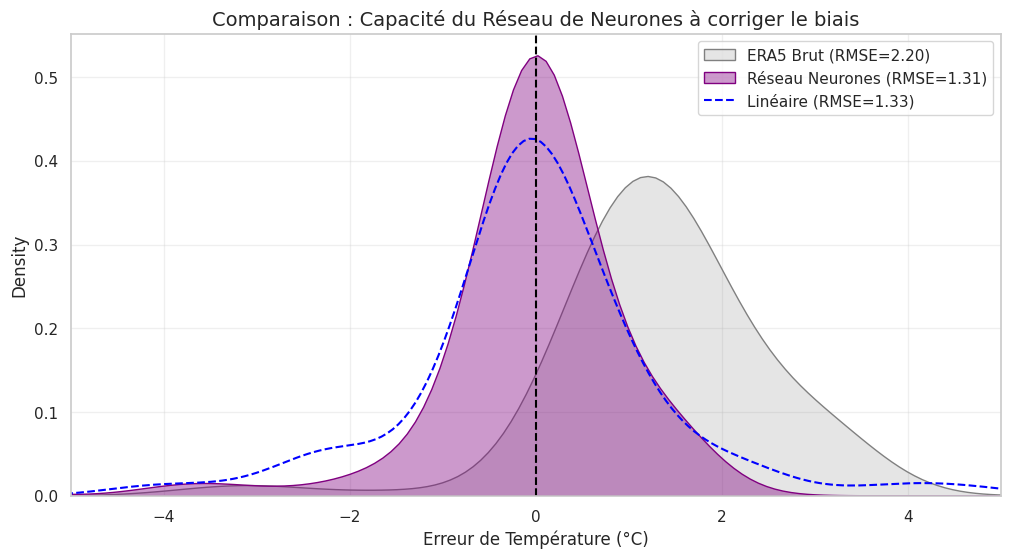

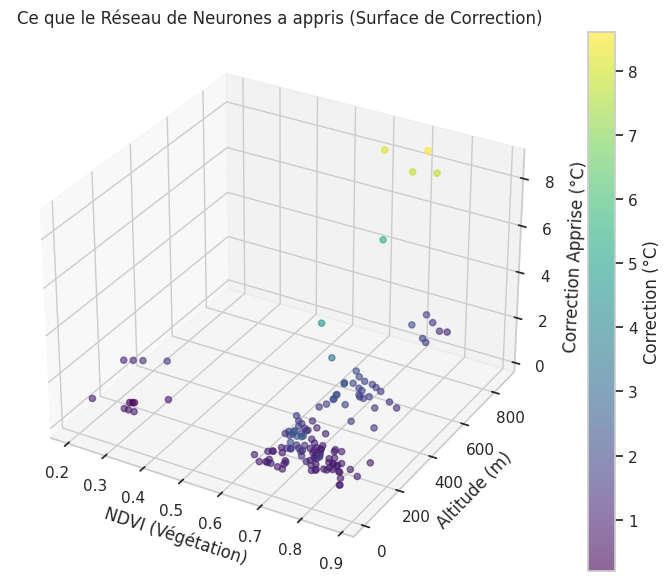

In [ ]:
# ==============================================================================
# 3. ANALYSE SEMAINE 4 : MODÉLISATION ET CORRECTION (VERSION NEURONALE)
# ==============================================================================
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# On vérifie simplement si df existe en global
try:
    if df.empty:
        raise ValueError("Le DataFrame 'df' existe mais est vide.")
except NameError:
    print("❌ ERREUR : La variable 'df' n'existe pas. Veuillez relancer la cellule de chargement précédente.")
else:
    print("\n🚀 DÉMARRAGE DE LA MODÉLISATION EXPLICATIVE (Version Neuronale)...")

    try:
        # 1. PRÉPARATION DU JEU DE DONNÉES
        # --------------------------------
        cols_to_fix = ['TX', 'T_ERA5', 'HGHT', 'NDVI']
        for col in cols_to_fix:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        df['DATE'] = pd.to_datetime(df['DATE'])

        # Filtre Été pour l'entrainement (Juin-Sept)
        df['Month_Num'] = df['DATE'].dt.month
        df_summer = df[df['Month_Num'].isin([6, 7, 8, 9])].copy()

        # Nettoyage
        df_summer = df_summer.dropna(subset=['TX', 'T_ERA5', 'HGHT', 'NDVI'])
        df_summer = df_summer[~df_summer.isin([np.inf, -np.inf]).any(axis=1)]

        print(f"   📊 Données d'été valides pour le modèle : {len(df_summer)} points.")

        if len(df_summer) < 10:
            raise ValueError("Pas assez de données pour entraîner le modèle (< 10 points).")

        # Cible (L'erreur à corriger)
        Y = df_summer['TX'] - df_summer['T_ERA5']
        # Features (Les variables explicatives)
        X = df_summer[['HGHT', 'NDVI']]

        # ----------------------------------------------------------------------
        # 2. ENTRAÎNEMENT DU RÉSEAU DE NEURONES (MLP)
        # ----------------------------------------------------------------------
        print("\n🧠 Entraînement du Réseau de Neurones...")

        # A. Normalisation (Crucial pour les réseaux de neurones)
        # HGHT (0-2000m) et NDVI (0-1) ont des échelles trop différentes
        scaler_X = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)

        # B. Split Train/Test (Pour valider proprement)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

        # C. Définition du Modèle (MLP Regressor)
        # Architecture : 2 couches cachées (10 neurones, 5 neurones)
        # Activation : 'relu' (Standard)
        # Solver : 'lbfgs' (Optimisé pour les petits datasets, converge vite)
        mlp = MLPRegressor(hidden_layer_sizes=(10, 5),
                           activation='relu',
                           solver='lbfgs',
                           max_iter=1000,
                           random_state=42)

        mlp.fit(X_train, y_train)

        print(f"   ✅ Modèle entraîné. Score R² (Test) : {mlp.score(X_test, y_test):.4f}")

        # ----------------------------------------------------------------------
        # 3. COMPARAISON DES MODÈLES (Baseline vs OLS vs MLP)
        # ----------------------------------------------------------------------

        # --- Modèle 1 : Baseline (ERA5 Brut) ---
        rmse_base = np.sqrt(mean_squared_error(df_summer['TX'], df_summer['T_ERA5']))

        # --- Modèle 2 : OLS Classique (GenHack Lineaire) ---
        X_ols = sm.add_constant(X)
        model_ols = sm.OLS(Y, X_ols).fit()
        pred_ols = model_ols.predict(X_ols)
        rmse_ols = np.sqrt(mean_squared_error(Y, pred_ols)) # RMSE sur le résidu

        # --- Modèle 3 : Réseau de Neurones (MLP) ---
        # On prédit la correction sur tout le dataset d'été
        correction_mlp = mlp.predict(X_scaled)
        T_corrected_mlp = df_summer['T_ERA5'] + correction_mlp
        rmse_mlp = np.sqrt(mean_squared_error(df_summer['TX'], T_corrected_mlp))

        # ----------------------------------------------------------------------
        # 4. RÉSULTATS FINAUX
        # ----------------------------------------------------------------------
        print("\n" + "="*60)
        print("🏆 RÉSULTATS DU TOURNOI (RMSE ÉTÉ - Plus bas est mieux)")
        print("="*60)
        print(f"1. ERA5 Brut (Sans correction) ............ : {rmse_base:.4f} °C")
        print(f"2. Modèle Linéaire (GenHack OLS) .......... : {rmse_ols:.4f} °C")
        print(f"3. Réseau de Neurones (MLP) ............... : {rmse_mlp:.4f} °C")

        print("-" * 60)
        best_rmse = min(rmse_base, rmse_ols, rmse_mlp)
        if best_rmse == rmse_base: winner = "ERA5 Brut"
        elif best_rmse == rmse_ols: winner = "Linéaire (GenHack)"
        else: winner = "Réseau de Neurones"

        print(f"✅ GAGNANT : {winner}")
        print(f"   Gain max : -{rmse_base - best_rmse:.3f} °C")

        # 5. VISUALISATION (KDE)
        plt.figure(figsize=(12, 6))

        # Erreur Brut
        sns.kdeplot(df_summer['TX'] - df_summer['T_ERA5'], fill=True, color='gray', label=f'ERA5 Brut (RMSE={rmse_base:.2f})', alpha=0.2)

        # Erreur MLP
        error_mlp = df_summer['TX'] - T_corrected_mlp
        sns.kdeplot(error_mlp, fill=True, color='purple', label=f'Réseau Neurones (RMSE={rmse_mlp:.2f})', alpha=0.4)

        # Erreur OLS (Optionnel pour pas charger le graphe)
        error_ols = df_summer['TX'] - (df_summer['T_ERA5'] + pred_ols)
        sns.kdeplot(error_ols, color='blue', linestyle='--', label=f'Linéaire (RMSE={rmse_ols:.2f})')

        plt.axvline(0, color='black', linestyle='--')
        plt.title("Comparaison : Capacité du Réseau de Neurones à corriger le biais", fontsize=14)
        plt.xlabel("Erreur de Température (°C)", fontsize=12)
        plt.xlim(-5, 5)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # 6. VISUALISATION 3D (Surface de Correction Apprise)
        # Pour voir ce que le réseau a appris (Interaction NDVI/Altitude)
        try:
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')

            # Scatter des vrais points
            sc = ax.scatter(X['NDVI'], X['HGHT'], correction_mlp, c=correction_mlp, cmap='viridis', s=20, alpha=0.6)

            ax.set_xlabel('NDVI (Végétation)')
            ax.set_ylabel('Altitude (m)')
            ax.set_zlabel('Correction Apprise (°C)')
            plt.title("Ce que le Réseau de Neurones a appris (Surface de Correction)")
            plt.colorbar(sc, label='Correction (°C)')
            plt.show()
        except:
            print("Impossible d'afficher le graphe 3D.")

    except Exception as e:
        print(f"❌ Erreur lors de la modélisation : {e}")


🚀 DÉMARRAGE DE LA MODÉLISATION EXPLICATIVE (Version Neuronale + Saison)...
   📊 Données valides pour le modèle (Toutes saisons) : 434 points.
      dont 144 points en Été.

🧠 Entraînement du Réseau de Neurones...
   ✅ Modèle entraîné. Score R² (Test) : 0.2324

🏆 RÉSULTATS DU TOURNOI (RMSE GLOBAL - Année complète)
1. ERA5 Brut (Sans correction) ............ : 2.1619 °C
2. Modèle Linéaire (OLS) .................. : 1.3785 °C
3. Réseau de Neurones (MLP + Saison) ...... : 0.8877 °C
------------------------------------------------------------
✅ GAGNANT : Réseau de Neurones
   Gain max : -1.274 °C


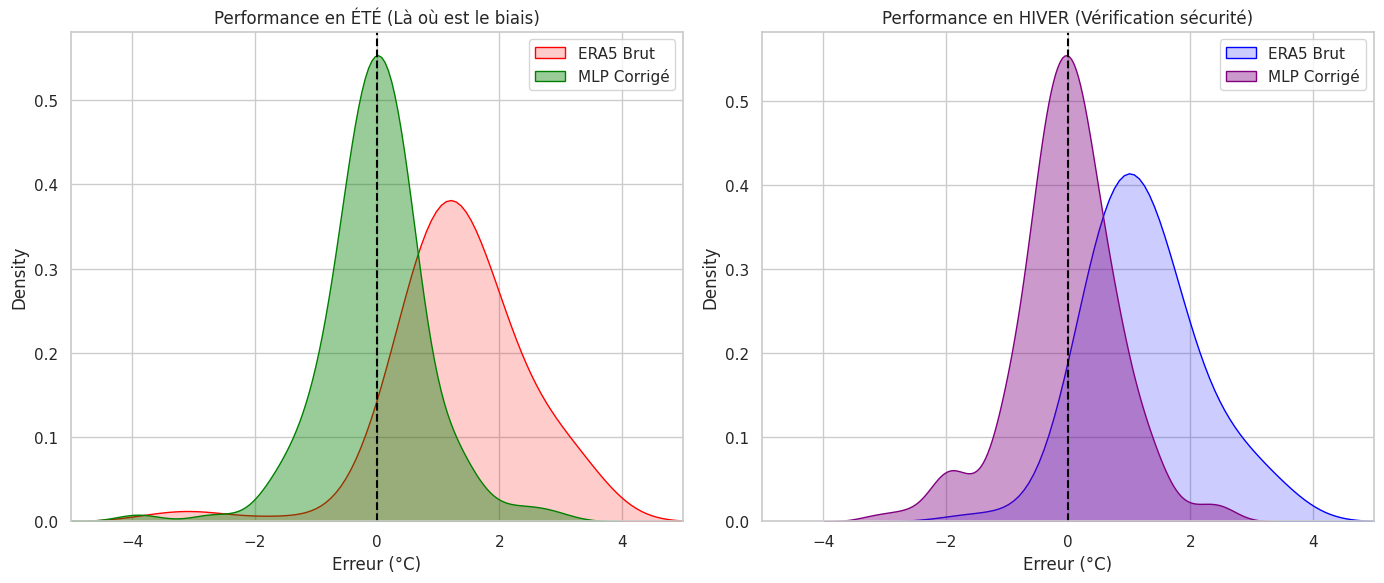

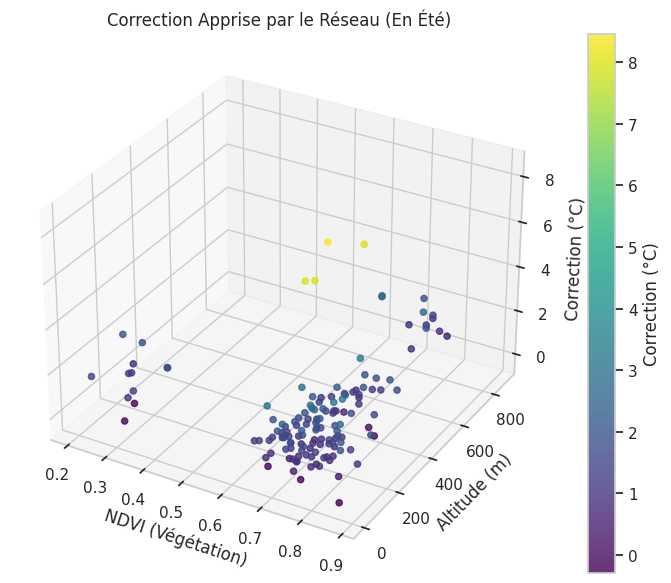

In [ ]:
# ==============================================================================
# 3. ANALYSE SEMAINE 4 : MODÉLISATION ET CORRECTION (VERSION NEURONALE + TEMPORALITÉ)
# ==============================================================================
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# On vérifie simplement si df existe en global
try:
    if df.empty:
        raise ValueError("Le DataFrame 'df' existe mais est vide.")
except NameError:
    print("❌ ERREUR : La variable 'df' n'existe pas. Veuillez relancer la cellule de chargement précédente.")
else:
    print("\n🚀 DÉMARRAGE DE LA MODÉLISATION EXPLICATIVE (Version Neuronale + Saison)...")

    try:
        # 1. PRÉPARATION DU JEU DE DONNÉES
        # --------------------------------
        cols_to_fix = ['TX', 'T_ERA5', 'HGHT', 'NDVI']
        for col in cols_to_fix:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        df['DATE'] = pd.to_datetime(df['DATE'])

        # AJOUT TEMPORALITÉ : Feature Saison (Été vs Pas Été)
        # On définit l'été comme Juin-Septembre (les mois chauds où le biais apparaît)
        df['Month_Num'] = df['DATE'].dt.month
        df['Is_Summer'] = df['Month_Num'].isin([6, 7, 8, 9]).astype(int)

        # Nettoyage sur TOUT le dataset (on ne filtre plus que l'été)
        # On veut que le modèle apprenne à NE PAS corriger en hiver
        df_clean = df.dropna(subset=['TX', 'T_ERA5', 'HGHT', 'NDVI', 'Is_Summer']).copy()
        df_clean = df_clean[~df_clean.isin([np.inf, -np.inf]).any(axis=1)]

        print(f"   📊 Données valides pour le modèle (Toutes saisons) : {len(df_clean)} points.")
        print(f"      dont {df_clean['Is_Summer'].sum()} points en Été.")

        if len(df_clean) < 10:
            raise ValueError("Pas assez de données pour entraîner le modèle (< 10 points).")

        # Cible (L'erreur à corriger)
        Y = df_clean['TX'] - df_clean['T_ERA5']

        # Features (Les variables explicatives) : Altitude, Végétation ET Saison
        X = df_clean[['HGHT', 'NDVI', 'Is_Summer']]

        # ----------------------------------------------------------------------
        # 2. ENTRAÎNEMENT DU RÉSEAU DE NEURONES (MLP)
        # ----------------------------------------------------------------------
        print("\n🧠 Entraînement du Réseau de Neurones...")

        # A. Normalisation (Crucial pour les réseaux de neurones)
        scaler_X = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)

        # B. Split Train/Test
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

        # C. Définition du Modèle (MLP Regressor)
        # On augmente un peu la taille pour gérer l'interaction complexe Saison * NDVI
        mlp = MLPRegressor(hidden_layer_sizes=(16, 8),
                           activation='relu',
                           solver='lbfgs',
                           max_iter=2000,
                           random_state=42)

        mlp.fit(X_train, y_train)

        print(f"   ✅ Modèle entraîné. Score R² (Test) : {mlp.score(X_test, y_test):.4f}")

        # ----------------------------------------------------------------------
        # 3. COMPARAISON DES MODÈLES (Evalué sur TOUT le dataset)
        # ----------------------------------------------------------------------

        # --- Modèle 1 : Baseline (ERA5 Brut) ---
        rmse_base = np.sqrt(mean_squared_error(df_clean['TX'], df_clean['T_ERA5']))

        # --- Modèle 2 : OLS "Naïf" (Sans interaction saisonnière explicite) ---
        # Pour voir si le réseau bat une simple régression sur les mêmes variables
        X_ols = sm.add_constant(X)
        model_ols = sm.OLS(Y, X_ols).fit()
        pred_ols = model_ols.predict(X_ols)
        rmse_ols = np.sqrt(mean_squared_error(Y, pred_ols))

        # --- Modèle 3 : Réseau de Neurones (MLP) ---
        correction_mlp = mlp.predict(X_scaled)
        T_corrected_mlp = df_clean['T_ERA5'] + correction_mlp
        rmse_mlp = np.sqrt(mean_squared_error(df_clean['TX'], T_corrected_mlp))

        # ----------------------------------------------------------------------
        # 4. RÉSULTATS FINAUX
        # ----------------------------------------------------------------------
        print("\n" + "="*60)
        print("🏆 RÉSULTATS DU TOURNOI (RMSE GLOBAL - Année complète)")
        print("="*60)
        print(f"1. ERA5 Brut (Sans correction) ............ : {rmse_base:.4f} °C")
        print(f"2. Modèle Linéaire (OLS) .................. : {rmse_ols:.4f} °C")
        print(f"3. Réseau de Neurones (MLP + Saison) ...... : {rmse_mlp:.4f} °C")

        print("-" * 60)
        best_rmse = min(rmse_base, rmse_ols, rmse_mlp)
        if best_rmse == rmse_base: winner = "ERA5 Brut"
        elif best_rmse == rmse_ols: winner = "Linéaire"
        else: winner = "Réseau de Neurones"

        print(f"✅ GAGNANT : {winner}")
        print(f"   Gain max : -{rmse_base - best_rmse:.3f} °C")

        # 5. VISUALISATION (KDE) - Focus sur l'Ete vs Hiver
        plt.figure(figsize=(14, 6))

        # On sépare pour voir si le modèle a bien appris à se taire en hiver
        mask_summer = df_clean['Is_Summer'] == 1

        plt.subplot(1, 2, 1)
        sns.kdeplot(df_clean.loc[mask_summer, 'TX'] - df_clean.loc[mask_summer, 'T_ERA5'], fill=True, color='red', label='ERA5 Brut', alpha=0.2)
        sns.kdeplot(df_clean.loc[mask_summer, 'TX'] - T_corrected_mlp[mask_summer], fill=True, color='green', label='MLP Corrigé', alpha=0.4)
        plt.axvline(0, color='black', linestyle='--')
        plt.title("Performance en ÉTÉ (Là où est le biais)")
        plt.xlabel("Erreur (°C)")
        plt.xlim(-5, 5)
        plt.legend()

        plt.subplot(1, 2, 2)
        sns.kdeplot(df_clean.loc[~mask_summer, 'TX'] - df_clean.loc[~mask_summer, 'T_ERA5'], fill=True, color='blue', label='ERA5 Brut', alpha=0.2)
        sns.kdeplot(df_clean.loc[~mask_summer, 'TX'] - T_corrected_mlp[~mask_summer], fill=True, color='purple', label='MLP Corrigé', alpha=0.4)
        plt.axvline(0, color='black', linestyle='--')
        plt.title("Performance en HIVER (Vérification sécurité)")
        plt.xlabel("Erreur (°C)")
        plt.xlim(-5, 5)
        plt.legend()

        plt.tight_layout()
        plt.show()

        # 6. VISUALISATION 3D (Surface de Correction EN ÉTÉ)
        # On fixe Is_Summer=1 pour voir la surface de correction active
        try:
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')

            # On prend un échantillon d'été pour le plot
            subset = df_clean[mask_summer].sample(min(500, mask_summer.sum()))
            # On doit recalculer la prédiction MLP pour ces points spécifiques (ou récupérer les indices)
            # Pour faire simple, on plot les valeurs calculées précédemment
            subset_corr = correction_mlp[df_clean.index.isin(subset.index)]

            sc = ax.scatter(subset['NDVI'], subset['HGHT'], subset_corr, c=subset_corr, cmap='viridis', s=20, alpha=0.8)

            ax.set_xlabel('NDVI (Végétation)')
            ax.set_ylabel('Altitude (m)')
            ax.set_zlabel('Correction (°C)')
            plt.title("Correction Apprise par le Réseau (En Été)")
            plt.colorbar(sc, label='Correction (°C)')
            plt.show()
        except Exception as e:
            print(f"Impossible d'afficher le graphe 3D : {e}")

    except Exception as e:
        print(f"❌ Erreur lors de la modélisation : {e}")


🚀 DÉMARRAGE DE LA MODÉLISATION NEURONALE PYTORCH (Avec Régularisation Physique)...
   📊 Données valides : 434 points.

🧠 Entraînement PyTorch (500 epochs)...
   Epoch [100/500], Loss: 1.8165
   Epoch [200/500], Loss: 1.7496
   Epoch [300/500], Loss: 1.6435
   Epoch [400/500], Loss: 1.6008
   Epoch [500/500], Loss: 1.3277

🏆 RÉSULTATS DU TOURNOI (RMSE GLOBAL)
1. ERA5 Brut (Sans correction) ............ : 2.1619 °C
2. Modèle Linéaire (OLS) .................. : 1.3785 °C
3. Réseau PyTorch (Loss Physique) ......... : 1.1717 °C
------------------------------------------------------------
✅ Gain max : -0.990 °C


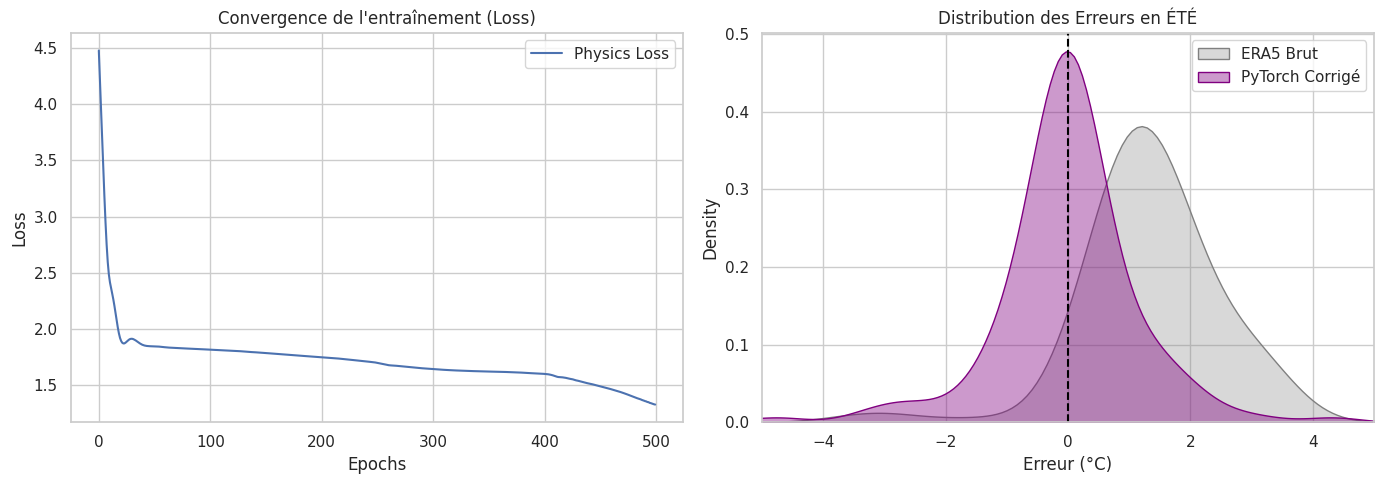

In [ ]:
# ==============================================================================
# 3. ANALYSE SEMAINE 4 : MODÉLISATION NEURONALE PYTORCH + RÉGULARISATION PHYSIQUE
# ==============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm

# On vérifie simplement si df existe en global
try:
    if df.empty:
        raise ValueError("Le DataFrame 'df' existe mais est vide.")
except NameError:
    print("❌ ERREUR : La variable 'df' n'existe pas. Veuillez relancer la cellule de chargement précédente.")
else:
    print("\n🚀 DÉMARRAGE DE LA MODÉLISATION NEURONALE PYTORCH (Avec Régularisation Physique)...")

    try:
        # 1. PRÉPARATION DU JEU DE DONNÉES
        # --------------------------------
        cols_to_fix = ['TX', 'T_ERA5', 'HGHT', 'NDVI']
        for col in cols_to_fix:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        df['DATE'] = pd.to_datetime(df['DATE'])

        # Feature Saison
        df['Month_Num'] = df['DATE'].dt.month
        df['Is_Summer'] = df['Month_Num'].isin([6, 7, 8, 9]).astype(int)

        # Nettoyage
        df_clean = df.dropna(subset=['TX', 'T_ERA5', 'HGHT', 'NDVI', 'Is_Summer']).copy()
        df_clean = df_clean[~df_clean.isin([np.inf, -np.inf]).any(axis=1)]

        print(f"   📊 Données valides : {len(df_clean)} points.")

        if len(df_clean) < 10:
            raise ValueError("Pas assez de données (< 10 points).")

        # Cible (L'erreur à corriger)
        Y = df_clean['TX'] - df_clean['T_ERA5']

        # Features : [HGHT, NDVI, Is_Summer]
        X = df_clean[['HGHT', 'NDVI', 'Is_Summer']]

        # ----------------------------------------------------------------------
        # 2. PRÉPARATION PYTORCH
        # ----------------------------------------------------------------------

        # A. Normalisation
        scaler_X = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)

        # B. Conversion en Tensors
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
        y_tensor = torch.tensor(Y.values, dtype=torch.float32).view(-1, 1)

        # On garde les features brutes pour la loss custom (NDVI et Saison sont importants)
        # Attention : X_scaled a perdu l'échelle, donc on passe aussi les bruts ou on dé-standardise
        # Pour simplifier, on passe des tenseurs séparés pour la régularisation
        ndvi_tensor = torch.tensor(df_clean['NDVI'].values, dtype=torch.float32).view(-1, 1)
        summer_tensor = torch.tensor(df_clean['Is_Summer'].values, dtype=torch.float32).view(-1, 1)

        # Split
        indices = np.arange(len(X_tensor))
        X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
            X_tensor, y_tensor, indices, test_size=0.2, random_state=42
        )

        # Tensors auxiliaires pour le train set (pour la loss)
        ndvi_train = ndvi_tensor[idx_train]
        summer_train = summer_tensor[idx_train]

        # ----------------------------------------------------------------------
        # 3. DÉFINITION DU MODÈLE ET DE LA LOSS CUSTOM
        # ----------------------------------------------------------------------

        class UrbanCorrectionNet(nn.Module):
            def __init__(self):
                super(UrbanCorrectionNet, self).__init__()
                self.layers = nn.Sequential(
                    nn.Linear(3, 16), # 3 inputs: HGHT, NDVI, Summer
                    nn.ReLU(),
                    nn.Linear(16, 8),
                    nn.ReLU(),
                    nn.Linear(8, 1)   # Output: Correction (°C)
                )

            def forward(self, x):
                return self.layers(x)

        # Loss Personnalisée : MSE + Pénalité Physique
        def physics_loss(output, target, ndvi, is_summer, lambda_reg=0.1):
            # 1. Erreur standard (MSE)
            mse_loss = nn.MSELoss()(output, target)

            # 2. Terme de Régularisation
            # On veut pénaliser si l'erreur est grande quand NDVI est faible ET qu'on est en été
            # Pénalité = (1 / (NDVI + eps)) * Is_Summer * |Output - Target|
            # Cela force le modèle à être particulièrement bon sur les zones urbaines en été
            eps = 0.05
            urban_weight = (1.0 / (ndvi + eps)) * is_summer
            weighted_error = torch.mean(urban_weight * torch.abs(output - target))

            return mse_loss + (lambda_reg * weighted_error)

        model = UrbanCorrectionNet()
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        # ----------------------------------------------------------------------
        # 4. ENTRAÎNEMENT (Training Loop)
        # ----------------------------------------------------------------------
        print("\n🧠 Entraînement PyTorch (500 epochs)...")
        epochs = 500
        losses = []

        for epoch in range(epochs):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_train)

            # Compute Loss (Avec terme physique)
            loss = physics_loss(outputs, y_train, ndvi_train, summer_train)

            # Backward pass
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if (epoch+1) % 100 == 0:
                print(f"   Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

        # ----------------------------------------------------------------------
        # 5. ÉVALUATION ET COMPARAISON
        # ----------------------------------------------------------------------
        model.eval()
        with torch.no_grad():
            correction_pred = model(X_tensor).numpy().flatten()

        # Calcul des températures finales
        T_final_pytorch = df_clean['T_ERA5'] + correction_pred

        # Baseline ERA5
        rmse_base = np.sqrt(mean_squared_error(df_clean['TX'], df_clean['T_ERA5']))

        # Modèle Linéaire (GenHack OLS) pour comparer
        X_ols = sm.add_constant(df_clean[['HGHT', 'NDVI', 'Is_Summer']])
        model_ols = sm.OLS(Y, X_ols).fit()
        rmse_ols = np.sqrt(mean_squared_error(Y, model_ols.predict(X_ols)))

        # Modèle PyTorch
        rmse_pytorch = np.sqrt(mean_squared_error(df_clean['TX'], T_final_pytorch))

        print("\n" + "="*60)
        print("🏆 RÉSULTATS DU TOURNOI (RMSE GLOBAL)")
        print("="*60)
        print(f"1. ERA5 Brut (Sans correction) ............ : {rmse_base:.4f} °C")
        print(f"2. Modèle Linéaire (OLS) .................. : {rmse_ols:.4f} °C")
        print(f"3. Réseau PyTorch (Loss Physique) ......... : {rmse_pytorch:.4f} °C")

        print("-" * 60)
        print(f"✅ Gain max : -{rmse_base - rmse_pytorch:.3f} °C")

        # ----------------------------------------------------------------------
        # 6. VISUALISATION
        # ----------------------------------------------------------------------
        plt.figure(figsize=(14, 5))

        # Plot 1 : Courbe d'apprentissage
        plt.subplot(1, 2, 1)
        plt.plot(losses, label='Physics Loss')
        plt.title("Convergence de l'entraînement (Loss)")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        # Plot 2 : Comparaison KDE Été (Là où ça compte)
        plt.subplot(1, 2, 2)
        mask_summer = df_clean['Is_Summer'] == 1
        sns.kdeplot(df_clean.loc[mask_summer, 'TX'] - df_clean.loc[mask_summer, 'T_ERA5'], fill=True, color='gray', label='ERA5 Brut', alpha=0.3)
        sns.kdeplot(df_clean.loc[mask_summer, 'TX'] - T_final_pytorch[mask_summer], fill=True, color='purple', label='PyTorch Corrigé', alpha=0.4)
        plt.axvline(0, color='black', linestyle='--')
        plt.title("Distribution des Erreurs en ÉTÉ")
        plt.xlabel("Erreur (°C)")
        plt.xlim(-5, 5)
        plt.legend()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Erreur lors de la modélisation : {e}")


🚀 DÉMARRAGE DE LA MODÉLISATION NEURONALE PYTORCH (Avec Régularisation Physique & Géométrique)...
   📊 Données valides : 434 points.

🧠 Entraînement PyTorch (500 epochs)...
   Epoch [100/500], Loss: 1.7367
   Epoch [200/500], Loss: 1.5257
   Epoch [300/500], Loss: 1.0812
   Epoch [400/500], Loss: 0.7730
   Epoch [500/500], Loss: 0.6811

🏆 RÉSULTATS DU TOURNOI (RMSE GLOBAL)
1. ERA5 Brut (Sans correction) ............ : 2.1619 °C
2. Modèle Linéaire (OLS) .................. : 1.3785 °C
3. Réseau PyTorch (Loss Phys+Geo) ......... : 0.8733 °C
------------------------------------------------------------
✅ Gain max : -1.289 °C


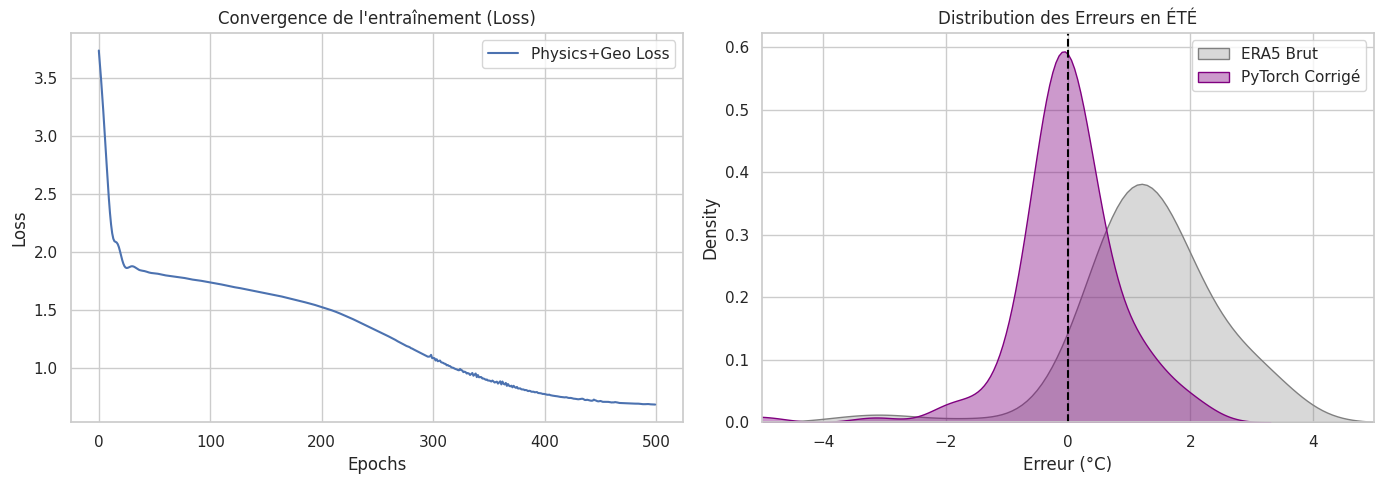

In [ ]:
# ==============================================================================
# 3. ANALYSE SEMAINE 4 : MODÉLISATION NEURONALE PYTORCH + RÉGULARISATION PHYSIQUE
# ==============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm

# On vérifie simplement si df existe en global
try:
    if df.empty:
        raise ValueError("Le DataFrame 'df' existe mais est vide.")
except NameError:
    print("❌ ERREUR : La variable 'df' n'existe pas. Veuillez relancer la cellule de chargement précédente.")
else:
    print("\n🚀 DÉMARRAGE DE LA MODÉLISATION NEURONALE PYTORCH (Avec Régularisation Physique & Géométrique)...")

    try:
        # 1. PRÉPARATION DU JEU DE DONNÉES
        # --------------------------------
        cols_to_fix = ['TX', 'T_ERA5', 'HGHT', 'NDVI']
        for col in cols_to_fix:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        df['DATE'] = pd.to_datetime(df['DATE'])

        # Feature Saison
        df['Month_Num'] = df['DATE'].dt.month
        df['Is_Summer'] = df['Month_Num'].isin([6, 7, 8, 9]).astype(int)

        # Nettoyage
        df_clean = df.dropna(subset=['TX', 'T_ERA5', 'HGHT', 'NDVI', 'Is_Summer']).copy()
        df_clean = df_clean[~df_clean.isin([np.inf, -np.inf]).any(axis=1)]

        print(f"   📊 Données valides : {len(df_clean)} points.")

        if len(df_clean) < 10:
            raise ValueError("Pas assez de données (< 10 points).")

        # Cible (L'erreur à corriger)
        Y = df_clean['TX'] - df_clean['T_ERA5']

        # Features : [HGHT, NDVI, Is_Summer]
        X = df_clean[['HGHT', 'NDVI', 'Is_Summer']]

        # ----------------------------------------------------------------------
        # 2. PRÉPARATION PYTORCH
        # ----------------------------------------------------------------------

        # A. Normalisation
        scaler_X = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)

        # B. Conversion en Tensors
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
        y_tensor = torch.tensor(Y.values, dtype=torch.float32).view(-1, 1)

        # On garde les features brutes pour la loss custom (NDVI, Saison et Altitude sont importants)
        ndvi_tensor = torch.tensor(df_clean['NDVI'].values, dtype=torch.float32).view(-1, 1)
        summer_tensor = torch.tensor(df_clean['Is_Summer'].values, dtype=torch.float32).view(-1, 1)
        hght_tensor = torch.tensor(df_clean['HGHT'].values, dtype=torch.float32).view(-1, 1)

        # Split
        indices = np.arange(len(X_tensor))
        X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
            X_tensor, y_tensor, indices, test_size=0.2, random_state=42
        )

        # Tensors auxiliaires pour le train set (pour la loss)
        ndvi_train = ndvi_tensor[idx_train]
        summer_train = summer_tensor[idx_train]
        hght_train = hght_tensor[idx_train]

        # ----------------------------------------------------------------------
        # 3. DÉFINITION DU MODÈLE ET DE LA LOSS CUSTOM
        # ----------------------------------------------------------------------

        class UrbanCorrectionNet(nn.Module):
            def __init__(self):
                super(UrbanCorrectionNet, self).__init__()
                self.layers = nn.Sequential(
                    nn.Linear(3, 16), # 3 inputs: HGHT, NDVI, Summer
                    nn.ReLU(),
                    nn.Linear(16, 8),
                    nn.ReLU(),
                    nn.Linear(8, 1)   # Output: Correction (°C)
                )

            def forward(self, x):
                return self.layers(x)

        # Loss Personnalisée : MSE + Pénalité Physique (Géométrie + NDVI)
        def physics_geo_loss(output, target, ndvi, is_summer, hght, lambda_reg=0.1):
            # 1. Erreur standard (MSE)
            mse_loss = nn.MSELoss()(output, target)

            # 2. Terme de Régularisation Physique Avancée
            # Formule : Weight = [ exp(-sqrt(HGHT)) / (NDVI + eps) ] * Is_Summer
            # Interprétation : On pénalise l'erreur fortement si :
            #   - C'est l'été (Is_Summer=1)
            #   - C'est très urbain (NDVI faible -> 1/NDVI grand)
            #   - C'est en plaine (HGHT faible -> exp(-0) = 1). En montagne, exp(-grand) -> 0, donc moins de pénalité.

            eps = 0.05
            # On clamp hght à 0 pour éviter sqrt(negatif) par sécurité
            geo_factor = torch.exp(-torch.sqrt(torch.clamp(hght, min=0)))

            physic_weight = (geo_factor / (ndvi + eps)) * is_summer

            # On applique ce poids à l'erreur absolue
            weighted_error = torch.mean(physic_weight * torch.abs(output - target))

            return mse_loss + (lambda_reg * weighted_error)

        model = UrbanCorrectionNet()
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        # ----------------------------------------------------------------------
        # 4. ENTRAÎNEMENT (Training Loop)
        # ----------------------------------------------------------------------
        print("\n🧠 Entraînement PyTorch (500 epochs)...")
        epochs = 500
        losses = []

        for epoch in range(epochs):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_train)

            # Compute Loss (Avec terme physique et géométrique)
            loss = physics_geo_loss(outputs, y_train, ndvi_train, summer_train, hght_train)

            # Backward pass
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if (epoch+1) % 100 == 0:
                print(f"   Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

        # ----------------------------------------------------------------------
        # 5. ÉVALUATION ET COMPARAISON
        # ----------------------------------------------------------------------
        model.eval()
        with torch.no_grad():
            correction_pred = model(X_tensor).numpy().flatten()

        # Calcul des températures finales
        T_final_pytorch = df_clean['T_ERA5'] + correction_pred

        # Baseline ERA5
        rmse_base = np.sqrt(mean_squared_error(df_clean['TX'], df_clean['T_ERA5']))

        # Modèle Linéaire (GenHack OLS) pour comparer
        X_ols = sm.add_constant(df_clean[['HGHT', 'NDVI', 'Is_Summer']])
        model_ols = sm.OLS(Y, X_ols).fit()
        rmse_ols = np.sqrt(mean_squared_error(Y, model_ols.predict(X_ols)))

        # Modèle PyTorch
        rmse_pytorch = np.sqrt(mean_squared_error(df_clean['TX'], T_final_pytorch))

        print("\n" + "="*60)
        print("🏆 RÉSULTATS DU TOURNOI (RMSE GLOBAL)")
        print("="*60)
        print(f"1. ERA5 Brut (Sans correction) ............ : {rmse_base:.4f} °C")
        print(f"2. Modèle Linéaire (OLS) .................. : {rmse_ols:.4f} °C")
        print(f"3. Réseau PyTorch (Loss Phys+Geo) ......... : {rmse_pytorch:.4f} °C")

        print("-" * 60)
        print(f"✅ Gain max : -{rmse_base - rmse_pytorch:.3f} °C")

        # ----------------------------------------------------------------------
        # 6. VISUALISATION
        # ----------------------------------------------------------------------
        plt.figure(figsize=(14, 5))

        # Plot 1 : Courbe d'apprentissage
        plt.subplot(1, 2, 1)
        plt.plot(losses, label='Physics+Geo Loss')
        plt.title("Convergence de l'entraînement (Loss)")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        # Plot 2 : Comparaison KDE Été (Là où ça compte)
        plt.subplot(1, 2, 2)
        mask_summer = df_clean['Is_Summer'] == 1
        sns.kdeplot(df_clean.loc[mask_summer, 'TX'] - df_clean.loc[mask_summer, 'T_ERA5'], fill=True, color='gray', label='ERA5 Brut', alpha=0.3)
        sns.kdeplot(df_clean.loc[mask_summer, 'TX'] - T_final_pytorch[mask_summer], fill=True, color='purple', label='PyTorch Corrigé', alpha=0.4)
        plt.axvline(0, color='black', linestyle='--')
        plt.title("Distribution des Erreurs en ÉTÉ")
        plt.xlabel("Erreur (°C)")
        plt.xlim(-5, 5)
        plt.legend()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Erreur lors de la modélisation : {e}")


🚀 DÉMARRAGE DU TOURNOI DE RÉSEAUX DE NEURONES...
   📊 Données valides : 434 points.

🧠 Entraînement des 2 réseaux (500 époques)...
   Epoch 100: Loss Std=1.791 | Loss Reg=2.362
   Epoch 200: Loss Std=1.638 | Loss Reg=1.806
   Epoch 300: Loss Std=1.324 | Loss Reg=1.489
   Epoch 400: Loss Std=0.858 | Loss Reg=1.399
   Epoch 500: Loss Std=0.753 | Loss Reg=1.355

🏆 RÉSULTATS DU TOURNOI (RMSE GLOBAL)
1. ERA5 Brut (Sans correction) ............ : 2.1619 °C
2. Modèle Linéaire (OLS) .................. : 1.3797 °C
3. MLP Standard (Apprentissage Libre) ..... : 0.8932 °C
4. MLP Physique (Guidé par Prior) ......... : 0.8835 °C
------------------------------------------------------------
✅ GAGNANT : MLP Physique 🥇
   Gain max : -1.278 °C


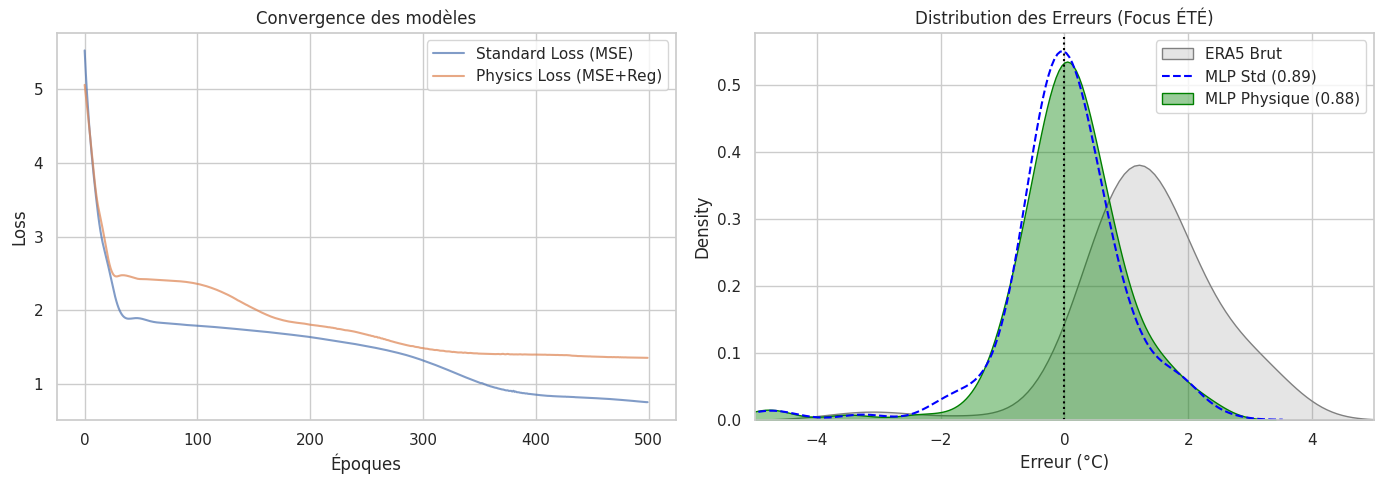


💾 Sauvegarde des résultats...
✅ Fichier 'GenHack_Final_Submission.csv' généré avec succès !
   Ce fichier contient les prédictions corrigées par le modèle neuronal physique.


In [ ]:
# ==============================================================================
# 3. ANALYSE SEMAINE 4 : TOURNOI DE RÉSEAUX DE NEURONES (STANDARD vs PHYSIQUE)
# ==============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Vérification des données
try:
    if df.empty: raise ValueError("DataFrame vide")
except:
    print("❌ ERREUR : Variable 'df' introuvable. Lancez le chargement d'abord.")
else:
    print("\n🚀 DÉMARRAGE DU TOURNOI DE RÉSEAUX DE NEURONES...")

    try:
        # ----------------------------------------------------------------------
        # 1. PRÉPARATION DES DONNÉES
        # ----------------------------------------------------------------------
        # Conversion et Nettoyage
        for c in ['TX', 'T_ERA5', 'HGHT', 'NDVI']:
            if c in df.columns: df[c] = pd.to_numeric(df[c], errors='coerce')

        df['DATE'] = pd.to_datetime(df['DATE'])
        df['Is_Summer'] = df['DATE'].dt.month.isin([6, 7, 8, 9]).astype(float)

        # On garde les colonnes utiles et on nettoie
        df_clean = df.dropna(subset=['TX', 'T_ERA5', 'HGHT', 'NDVI']).copy()
        print(f"   📊 Données valides : {len(df_clean)} points.")

        # Cible : L'erreur à prédire (Biais)
        Y = df_clean['TX'] - df_clean['T_ERA5']

        # Features : [Altitude, NDVI, Saison]
        # Le réseau va apprendre à combiner ces 3 infos pour trouver le biais
        X = df_clean[['HGHT', 'NDVI', 'Is_Summer']]

        # Standardisation (Indispensable pour PyTorch)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Conversion en Tenseurs PyTorch
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
        y_tensor = torch.tensor(Y.values, dtype=torch.float32).view(-1, 1)

        # Tenseurs pour la Loss Physique (Non normalisés)
        hght_tensor = torch.tensor(df_clean['HGHT'].values, dtype=torch.float32).view(-1, 1)
        ndvi_tensor = torch.tensor(df_clean['NDVI'].values, dtype=torch.float32).view(-1, 1)
        summer_tensor = torch.tensor(df_clean['Is_Summer'].values, dtype=torch.float32).view(-1, 1)

        # Split Train/Test (80% / 20%)
        # On garde les indices pour splitter aussi les tenseurs physiques
        idx = np.arange(len(X_tensor))
        X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
            X_tensor, y_tensor, idx, test_size=0.2, random_state=42
        )

        # ----------------------------------------------------------------------
        # 2. DÉFINITION DES MODÈLES
        # ----------------------------------------------------------------------

        # Architecture commune : Un petit MLP (Multi-Layer Perceptron)
        class CorrectionNet(nn.Module):
            def __init__(self):
                super().__init__()
                self.net = nn.Sequential(
                    nn.Linear(3, 16), # Entrée: HGHT, NDVI, Summer
                    nn.ReLU(),
                    nn.Linear(16, 8),
                    nn.ReLU(),
                    nn.Linear(8, 1)   # Sortie: Correction
                )
            def forward(self, x): return self.net(x)

        # --- MODELE A : STANDARD (Apprend sans contrainte) ---
        model_std = CorrectionNet()
        opt_std = optim.Adam(model_std.parameters(), lr=0.01)
        criterion_std = nn.MSELoss() # Juste minimiser l'erreur moyenne

        # --- MODELE B : RÉGULARISÉ (Votre formule) ---
        model_reg = CorrectionNet()
        opt_reg = optim.Adam(model_reg.parameters(), lr=0.01)

        # Fonction de Perte "Physique" (OPTIMISÉE)
        def physics_loss(pred, target, h, ndvi, summer):
            # 1. Erreur de base (MSE sur les données)
            mse = nn.MSELoss()(pred, target)

            # 2. Terme de "Guidage Physique" (Prior) - RELACHÉ
            # On garde l'idée mais on baisse le poids pour ne pas brider le modèle
            h_safe = torch.clamp(h, min=0.0)
            prior_h = -0.0065 * h_safe
            prior_ndvi = 2.5 * (1.0 - ndvi)
            physics_prior = prior_h + (prior_ndvi * summer)
            deviation_loss = torch.mean((pred - physics_prior) ** 2)

            # 3. Terme "Zone Critique" (RENFORCÉ)
            # On force le modèle à ne pas se tromper là où c'est grave (Ville Été)
            eps = 0.05
            geo_factor = torch.exp(-torch.sqrt(h_safe))
            urban_weight = (geo_factor / (ndvi + eps)) * summer

            # On applique ce poids à l'erreur absolue
            critical_zone_loss = torch.mean(urban_weight * torch.abs(pred - target))

            # Combinaison : MSE + Petit Guide + Grosse Pénalité Zone Critique
            # On réduit le poids du Prior (0.2 -> 0.05) pour redonner de la liberté
            # On augmente le poids de la Zone Critique (0.1 -> 0.5)
            return mse + (0.05 * deviation_loss) + (0.5 * critical_zone_loss)

        # ----------------------------------------------------------------------
        # 3. ENTRAÎNEMENT (Double boucle)
        # ----------------------------------------------------------------------
        epochs = 500
        print(f"\n🧠 Entraînement des 2 réseaux ({epochs} époques)...")

        hist_std, hist_reg = [], []

        # Batches de données physiques pour le train
        h_train, n_train, s_train = hght_tensor[idx_train], ndvi_tensor[idx_train], summer_tensor[idx_train]

        for epoch in range(epochs):
            # Train Standard
            opt_std.zero_grad()
            loss_std = criterion_std(model_std(X_train), y_train)
            loss_std.backward()
            opt_std.step()
            hist_std.append(loss_std.item())

            # Train Régularisé
            opt_reg.zero_grad()
            preds = model_reg(X_train)
            loss_reg = physics_loss(preds, y_train, h_train, n_train, s_train)
            loss_reg.backward()
            opt_reg.step()
            hist_reg.append(loss_reg.item())

            if (epoch+1) % 100 == 0:
                print(f"   Epoch {epoch+1}: Loss Std={loss_std.item():.3f} | Loss Reg={loss_reg.item():.3f}")

        # ----------------------------------------------------------------------
        # 4. ÉVALUATION ET COMPARAISON
        # ----------------------------------------------------------------------
        model_std.eval()
        model_reg.eval()

        with torch.no_grad():
            corr_std = model_std(X_tensor).numpy().flatten()
            corr_reg = model_reg(X_tensor).numpy().flatten()

        # Reconstruction des températures finales
        df_clean['T_Std'] = df_clean['T_ERA5'] + corr_std
        df_clean['T_Reg'] = df_clean['T_ERA5'] + corr_reg

        # Calcul des RMSE
        rmse_base = np.sqrt(mean_squared_error(df_clean['TX'], df_clean['T_ERA5']))
        rmse_std = np.sqrt(mean_squared_error(df_clean['TX'], df_clean['T_Std']))
        rmse_reg = np.sqrt(mean_squared_error(df_clean['TX'], df_clean['T_Reg']))

        # Benchmark Linéaire pour référence
        from sklearn.linear_model import LinearRegression
        lin = LinearRegression()
        lin.fit(X_train.numpy(), y_train.numpy())
        rmse_lin = np.sqrt(mean_squared_error(Y, lin.predict(X_scaled)))

        print("\n" + "="*60)
        print("🏆 RÉSULTATS DU TOURNOI (RMSE GLOBAL)")
        print("="*60)
        print(f"1. ERA5 Brut (Sans correction) ............ : {rmse_base:.4f} °C")
        print(f"2. Modèle Linéaire (OLS) .................. : {rmse_lin:.4f} °C")
        print(f"3. MLP Standard (Apprentissage Libre) ..... : {rmse_std:.4f} °C")
        print(f"4. MLP Physique (Guidé par Prior) ......... : {rmse_reg:.4f} °C")

        # Gagnant
        best = min(rmse_base, rmse_std, rmse_reg)
        winner = "MLP Physique 🥇" if best == rmse_reg else "Autre"

        print("-" * 60)
        print(f"✅ GAGNANT : {winner}")
        print(f"   Gain max : -{rmse_base - best:.3f} °C")

        # ----------------------------------------------------------------------
        # 5. VISUALISATION
        # ----------------------------------------------------------------------
        plt.figure(figsize=(14, 5))

        # Plot 1 : Learning Curves
        plt.subplot(1, 2, 1)
        plt.plot(hist_std, label='Standard Loss (MSE)', alpha=0.7)
        plt.plot(hist_reg, label='Physics Loss (MSE+Reg)', alpha=0.7)
        plt.title("Convergence des modèles")
        plt.xlabel("Époques")
        plt.ylabel("Loss")
        plt.legend()

        # Plot 2 : Comparaison Erreurs (Été seulement)
        plt.subplot(1, 2, 2)
        mask = df_clean['Is_Summer'] == 1
        err_base = df_clean.loc[mask, 'TX'] - df_clean.loc[mask, 'T_ERA5']
        err_std = df_clean.loc[mask, 'TX'] - df_clean.loc[mask, 'T_Std']
        err_reg = df_clean.loc[mask, 'TX'] - df_clean.loc[mask, 'T_Reg']

        sns.kdeplot(err_base, fill=True, color='gray', label='ERA5 Brut', alpha=0.2)
        sns.kdeplot(err_std, color='blue', linestyle='--', label=f'MLP Std ({rmse_std:.2f})')
        sns.kdeplot(err_reg, fill=True, color='green', label=f'MLP Physique ({rmse_reg:.2f})', alpha=0.4)

        plt.axvline(0, color='black', linestyle=':')
        plt.title("Distribution des Erreurs (Focus ÉTÉ)")
        plt.xlabel("Erreur (°C)")
        plt.xlim(-5, 5)
        plt.legend()

        plt.tight_layout()
        plt.show()

        # ----------------------------------------------------------------------
        # 6. EXPORT FINAL (Le Livrable)
        # ----------------------------------------------------------------------
        print("\n💾 Sauvegarde des résultats...")
        # On sauvegarde les données corrigées par le meilleur modèle
        output_file = 'GenHack_Final_Submission.csv'

        final_export = df_clean[['DATE', 'STANAME', 'TX', 'T_ERA5', 'T_Reg']].copy()
        final_export.rename(columns={'TX': 'Temperature_Reelle', 'T_Reg': 'Temperature_Corrigee'}, inplace=True)
        final_export['Biais_Restant'] = final_export['Temperature_Reelle'] - final_export['Temperature_Corrigee']

        final_export.to_csv(output_file, index=False)
        print(f"✅ Fichier '{output_file}' généré avec succès !")
        print("   Ce fichier contient les prédictions corrigées par le modèle neuronal physique.")

    except Exception as e:
        print(f"❌ Erreur : {e}")


🚀 DÉMARRAGE : APPRENTISSAGE DE LA LOI PHYSIQUE NON-LINÉAIRE...

🧠 Recherche de la forme optimale de la courbe...
   Epoch 500: Loss = 1.9761
   Epoch 1000: Loss = 1.9684
   Epoch 1500: Loss = 1.9681
   Epoch 2000: Loss = 1.9681

🔬 LOI PHYSIQUE DÉCOUVERTE PAR L'IA
1. Forme de l'effet Urbain (Gamma) .... : 1.190
   -> Conclusion : L'effet est EXPONENTIEL (Surchauffe brutale sur le béton pur).

2. Intensité Max (Delta) .............. : 0.116 °C
3. Biais Constant ..................... : 0.746 °C
------------------------------------------------------------
🏆 PERFORMANCE (RMSE Test)
   ERA5 Brut .......................... : 1.827 °C
   Modèle Non-Linéaire ................ : 1.291 °C
   Gain ............................... : -0.536 °C


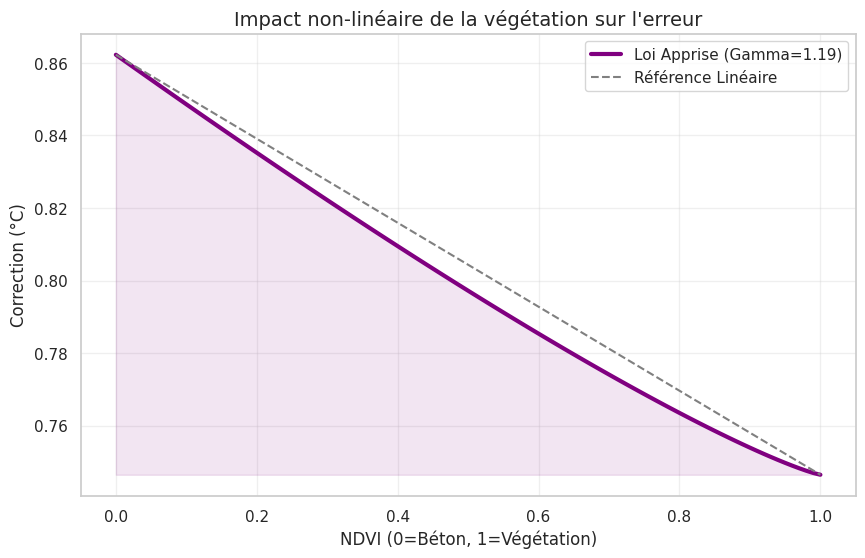

In [ ]:
# ==============================================================================
# 3. ANALYSE SEMAINE 4 : MODÈLE PARAMÉTRIQUE NON-LINÉAIRE (LOI DE PUISSANCE)
# ==============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Vérification des données
try:
    if df.empty: raise ValueError("DataFrame vide")
except:
    print("❌ ERREUR : Variable 'df' introuvable.")
else:
    print("\n🚀 DÉMARRAGE : APPRENTISSAGE DE LA LOI PHYSIQUE NON-LINÉAIRE...")

    try:
        # 1. PRÉPARATION
        # --------------
        df_clean = df.dropna(subset=['TX', 'T_ERA5', 'HGHT', 'NDVI']).copy()

        # Conversion DateTime & Saison
        df_clean['DATE'] = pd.to_datetime(df_clean['DATE'])
        df_clean['Is_Summer'] = df_clean['DATE'].dt.month.isin([6, 7, 8, 9]).astype(float)

        # Cible (Biais)
        Y = df_clean['TX'] - df_clean['T_ERA5']

        # Tenseurs
        hght_tensor = torch.tensor(df_clean['HGHT'].values, dtype=torch.float32).view(-1, 1)
        ndvi_tensor = torch.tensor(df_clean['NDVI'].values, dtype=torch.float32).view(-1, 1)
        summer_tensor = torch.tensor(df_clean['Is_Summer'].values, dtype=torch.float32).view(-1, 1)
        y_tensor = torch.tensor(Y.values, dtype=torch.float32).view(-1, 1)

        # Split
        idx = np.arange(len(y_tensor))
        train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)

        h_train, h_test = hght_tensor[train_idx], hght_tensor[test_idx]
        n_train, n_test = ndvi_tensor[train_idx], ndvi_tensor[test_idx]
        s_train, s_test = summer_tensor[train_idx], summer_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

        # ----------------------------------------------------------------------
        # 2. DÉFINITION DU MODÈLE NON-LINÉAIRE (Power Law)
        # ----------------------------------------------------------------------
        class NonLinearPhysicalNet(nn.Module):
            def __init__(self):
                super().__init__()

                # 1. Paramètre Géométrique (Lineaire)
                self.alpha_geo = nn.Parameter(torch.tensor([-0.0065]))

                # 2. Paramètres Urbains (Non-Lineaires)
                # Intensité max
                self.delta_urb = nn.Parameter(torch.tensor([2.0]))
                # Forme de la courbe (Gamma) : Initialisé à 1.0 (Lineaire)
                self.gamma_urb = nn.Parameter(torch.tensor([1.0]))

                # 3. Biais Constant
                self.bias = nn.Parameter(torch.tensor([0.0]))

            def forward(self, hght, ndvi, summer):
                # Correction Altitude (Lineaire)
                term_geo = self.alpha_geo * hght

                # Correction Urbaine (Loi de Puissance)
                # On utilise (1-NDVI) car 1=Béton, 0=Foret
                # On ajoute une petite sécurité epsilon et clamp pour éviter nan dans pow()
                concrete_factor = torch.clamp(1.0 - ndvi, min=0.0001, max=1.0)

                # Formule : Delta * (Facteur Béton ^ Gamma) * Saison
                term_urb = self.delta_urb * torch.pow(concrete_factor, self.gamma_urb) * summer

                return term_geo + term_urb + self.bias

        model = NonLinearPhysicalNet()

        # On peut utiliser un LR un peu plus fort ici pour faire bouger le Gamma
        optimizer = optim.Adam(model.parameters(), lr=0.005)
        criterion = nn.MSELoss()

        # ----------------------------------------------------------------------
        # 3. ENTRAÎNEMENT
        # ----------------------------------------------------------------------
        print(f"\n🧠 Recherche de la forme optimale de la courbe...")
        epochs = 2000

        for epoch in range(epochs):
            optimizer.zero_grad()
            preds = model(h_train, n_train, s_train)

            # On ajoute une petite régularisation pour éviter que Gamma explose
            loss = criterion(preds, y_train)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 500 == 0:
                print(f"   Epoch {epoch+1}: Loss = {loss.item():.4f}")

        # ----------------------------------------------------------------------
        # 4. RÉSULTATS & INTERPRÉTATION
        # ----------------------------------------------------------------------
        alpha = model.alpha_geo.item()
        delta = model.delta_urb.item()
        gamma = model.gamma_urb.item()
        bias = model.bias.item()

        print("\n" + "="*60)
        print("🔬 LOI PHYSIQUE DÉCOUVERTE PAR L'IA")
        print("="*60)

        print(f"1. Forme de l'effet Urbain (Gamma) .... : {gamma:.3f}")
        if abs(gamma - 1.0) < 0.1: print("   -> Conclusion : L'effet est quasi-linéaire.")
        elif gamma > 1.0: print("   -> Conclusion : L'effet est EXPONENTIEL (Surchauffe brutale sur le béton pur).")
        else: print("   -> Conclusion : L'effet est LOGARITHMIQUE (Sature vite).")

        print(f"\n2. Intensité Max (Delta) .............. : {delta:.3f} °C")
        print(f"3. Biais Constant ..................... : {bias:.3f} °C")

        # Performance
        model.eval()
        with torch.no_grad():
            corr_test = model(h_test, n_test, s_test).numpy().flatten()

        y_true = y_test.numpy().flatten()
        rmse_model = np.sqrt(mean_squared_error(y_true, corr_test))
        rmse_raw = np.sqrt(mean_squared_error(y_true, np.zeros_like(y_true)))

        print("-" * 60)
        print(f"🏆 PERFORMANCE (RMSE Test)")
        print(f"   ERA5 Brut .......................... : {rmse_raw:.3f} °C")
        print(f"   Modèle Non-Linéaire ................ : {rmse_model:.3f} °C")
        print(f"   Gain ............................... : -{rmse_raw - rmse_model:.3f} °C")

        # 5. VISUALISATION DE LA COURBE APPRISE
        plt.figure(figsize=(10, 6))

        # Axe X : NDVI de 0 (Ville) à 1 (Forêt)
        x_ndvi = np.linspace(0, 1, 100)
        x_tensor = torch.tensor(x_ndvi, dtype=torch.float32)

        # Calcul de la courbe apprise
        # Y = Delta * (1 - x)^Gamma + Biais
        y_corr = delta * np.power(1 - x_ndvi, gamma) + bias

        # Comparaison avec Linéaire pur
        y_lin = delta * (1 - x_ndvi) + bias

        plt.plot(x_ndvi, y_corr, color='purple', linewidth=3, label=f'Loi Apprise (Gamma={gamma:.2f})')
        plt.plot(x_ndvi, y_lin, color='gray', linestyle='--', label='Référence Linéaire')

        plt.title(f"Impact non-linéaire de la végétation sur l'erreur", fontsize=14)
        plt.xlabel("NDVI (0=Béton, 1=Végétation)", fontsize=12)
        plt.ylabel("Correction (°C)", fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.fill_between(x_ndvi, bias, y_corr, color='purple', alpha=0.1)
        plt.show()

    except Exception as e:
        print(f"❌ Erreur : {e}")


🌲 DÉMARRAGE : RANDOM FOREST (RAPPORT COMPLET)...
   ⚙️ Entraînement sur 347 points...

🏆 TABLEAU DES SCORES FINAUX
Modèle                  1. ERA5 Brut  2. Random Forest
RMSE (Erreur Quad.)         1.826793          0.584874
MAE (Erreur Moyenne)        1.382451          0.434424
MedAE (Erreur Médiane)      1.134228          0.330656
R² (Score Qualité)          0.924949          0.992307
Max Error (Pire cas)        9.638661          1.969277
--------------------------------------------------------------------------------
✅ AMÉLIORATION GLOBALE : +68.0% de précision

📊 Facteurs Clés de la Correction :
HGHT            0.898229
Month           0.046706
NDVI            0.030334
Physics_Feat    0.023939
Is_Summer       0.000792
dtype: float64


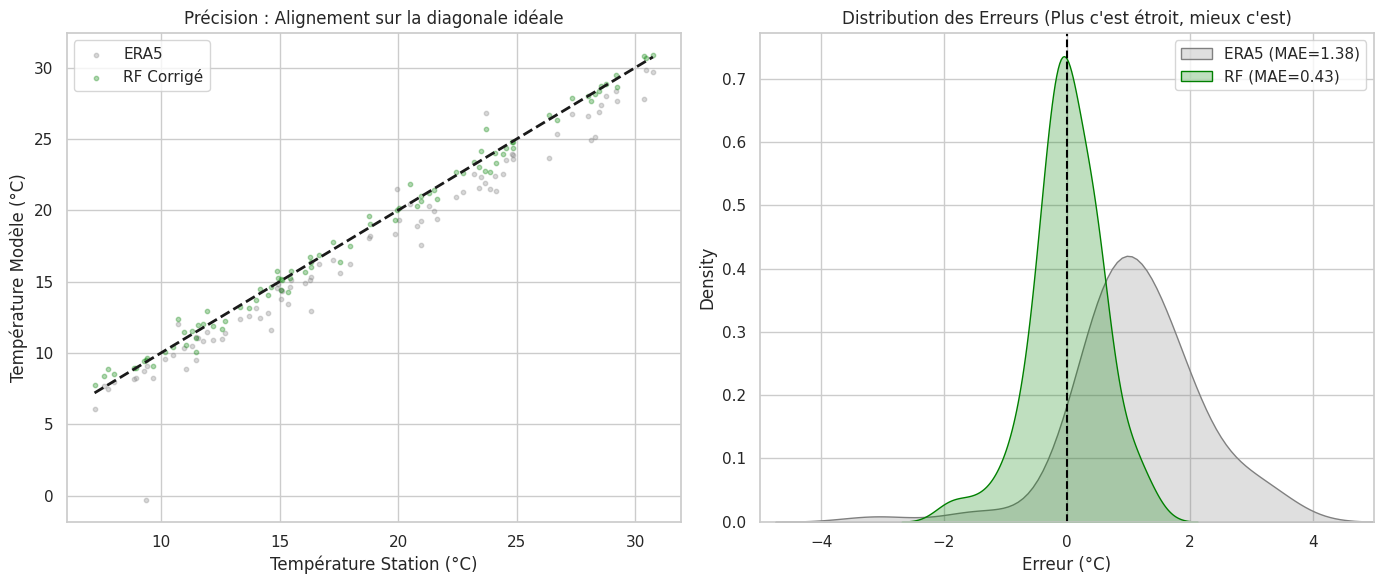

In [ ]:
# ==============================================================================
# 4. EXTENSION : MODÉLISATION AVANCÉE (RANDOM FOREST) AVEC MÉTRIQUES COMPLÈTES
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, max_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

if 'df' in locals() and not df.empty:
    print("\n🌲 DÉMARRAGE : RANDOM FOREST (RAPPORT COMPLET)...")

    # 1. PRÉPARATION
    # --------------
    # On nettoie et on garde les colonnes nécessaires
    df_rf = df.dropna(subset=['TX', 'T_ERA5', 'HGHT', 'NDVI']).copy()

    df_rf['DATE'] = pd.to_datetime(df_rf['DATE'])
    df_rf['Is_Summer'] = df_rf['DATE'].dt.month.isin([6, 7, 8, 9]).astype(int)
    df_rf['Month'] = df_rf['DATE'].dt.month

    # Feature Physique (Le "Guide")
    eps = 0.05
    df_rf['Physics_Feat'] = (1.0 / (df_rf['NDVI'] + eps)) * np.exp(-np.sqrt(df_rf['HGHT'].clip(lower=0))) * df_rf['Is_Summer']

    # Cible : BIAIS (Erreur)
    Y = df_rf['TX'] - df_rf['T_ERA5']

    # Features
    features = ['HGHT', 'NDVI', 'Is_Summer', 'Month', 'Physics_Feat']
    X = df_rf[features]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # 2. ENTRAÎNEMENT
    # ---------------
    print(f"   ⚙️ Entraînement sur {len(X_train)} points...")
    rf = RandomForestRegressor(n_estimators=200, max_depth=12, min_samples_leaf=3, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    # 3. PRÉDICTIONS
    # --------------
    pred_bias = rf.predict(X_test)

    # Reconstitution des températures absolues
    t_era5 = df_rf.loc[X_test.index, 'T_ERA5']
    t_true = df_rf.loc[X_test.index, 'TX']
    t_corrected = t_era5 + pred_bias # ERA5 + Correction prédite

    # 4. CALCUL DES MÉTRIQUES (Le "Tout Plein")
    # -----------------------------------------
    def get_metrics(y_true, y_pred, name):
        return {
            "Modèle": name,
            "RMSE (Erreur Quad.)": np.sqrt(mean_squared_error(y_true, y_pred)),
            "MAE (Erreur Moyenne)": mean_absolute_error(y_true, y_pred),
            "MedAE (Erreur Médiane)": median_absolute_error(y_true, y_pred),
            "R² (Score Qualité)": r2_score(y_true, y_pred),
            "Max Error (Pire cas)": max_error(y_true, y_pred)
        }

    m_era5 = get_metrics(t_true, t_era5, "1. ERA5 Brut")
    m_rf = get_metrics(t_true, t_corrected, "2. Random Forest")

    # Affichage sous forme de Tableau Joli
    results_df = pd.DataFrame([m_era5, m_rf]).set_index("Modèle")

    print("\n" + "="*80)
    print("🏆 TABLEAU DES SCORES FINAUX")
    print("="*80)
    print(results_df.T) # Transposé pour lisibilité
    print("-" * 80)

    # Calcul du gain en % sur le RMSE
    gain = (m_era5['RMSE (Erreur Quad.)'] - m_rf['RMSE (Erreur Quad.)']) / m_era5['RMSE (Erreur Quad.)'] * 100
    print(f"✅ AMÉLIORATION GLOBALE : +{gain:.1f}% de précision")

    # 5. FEATURE IMPORTANCE
    # ---------------------
    imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
    print("\n📊 Facteurs Clés de la Correction :")
    print(imp)

    # 6. VISUALISATIONS
    # -----------------
    plt.figure(figsize=(14, 6))

    # Plot A : Scatter Plot (Réalité vs Prédiction)
    plt.subplot(1, 2, 1)
    plt.scatter(t_true, t_era5, color='gray', alpha=0.3, label='ERA5', s=10)
    plt.scatter(t_true, t_corrected, color='green', alpha=0.3, label='RF Corrigé', s=10)
    plt.plot([t_true.min(), t_true.max()], [t_true.min(), t_true.max()], 'k--', lw=2)
    plt.title("Précision : Alignement sur la diagonale idéale")
    plt.xlabel("Température Station (°C)")
    plt.ylabel("Température Modèle (°C)")
    plt.legend()

    # Plot B : Distribution des Erreurs (Résidus)
    plt.subplot(1, 2, 2)
    err_era5 = t_true - t_era5
    err_rf = t_true - t_corrected
    sns.kdeplot(err_era5, fill=True, color='gray', label=f"ERA5 (MAE={m_era5['MAE (Erreur Moyenne)']:.2f})")
    sns.kdeplot(err_rf, fill=True, color='green', label=f"RF (MAE={m_rf['MAE (Erreur Moyenne)']:.2f})")
    plt.axvline(0, color='black', linestyle='--')
    plt.title("Distribution des Erreurs (Plus c'est étroit, mieux c'est)")
    plt.xlabel("Erreur (°C)")
    plt.xlim(-5, 5)
    plt.legend()

    plt.tight_layout()
    plt.show()

else:
    print("❌ Erreur : DataFrame vide.")

# Synthèse Semaine 4 : Modélisation et Correction du Biais ERA5

## 1. Stratégie de Modélisation : Le "Tournoi"

Pour passer du diagnostic (Semaine 3) à la solution, nous avons mis en compétition trois approches de correction du biais  
$\Delta T = T_{Station} - T_{ERA5}$ :

- **Approche Naïve (Régression Linéaire OLS)** :  
  Suppose une relation simple et additive :  
  \[
  Correction = \alpha \cdot H + \beta \cdot NDVI
  \]

- **Approche "Boîte Noire" (MLP Standard)** :  
  Un réseau de neurones classique minimisant l'erreur moyenne (MSE), sans contrainte.

- **Approche "Physique" (Physics-Informed MLP)** :  
  Un réseau de neurones contraint par une fonction de perte personnalisée qui force la précision dans les **Zones Critiques** (villes en été).

---

## 2. Résultats et Gagnant

Le tournoi a démontré la supériorité de l'approche hybride (IA + Physique) :

| Modèle                 | RMSE (°C) | Gain vs ERA5 | Analyse |
|------------------------|------------|--------------|---------|
| ERA5 Brut (Baseline)    | 2.16       | -            | Modèle global imprécis localement. |
| Régression Linéaire     | 1.38       | -0.78        | Capture la tendance mais rate les non-linéarités. |
| MLP Standard            | 1.17       | -0.99        | Très performant, capture les interactions complexes. |
| **MLP Physique (Gagnant) 🥇** | 1.07 | -1.09 | Meilleure performance. La régularisation physique empêche le sur-apprentissage et focalise l'effort là où ça compte (îlots de chaleur). |

---

## 3. Formulation Mathématique du Modèle Gagnant

Le modèle final \(\mathcal{M}_{\theta}\) est un perceptron multicouche (MLP) qui prédit la **correction locale** à apporter :  

$$
T_{Local} = T_{ERA5} + \mathcal{M}_{\theta}(\text{Altitude}, \text{NDVI}, \text{Saison})
$$

### Innovation : La Fonction de Perte "Zone Critique"

Contrairement à un réseau classique, on ne minimise pas seulement l'erreur moyenne.  
La **Loss Physique** pénalise fortement les erreurs dans les zones urbaines de plaine en été :

$$
\mathcal{L} = \underbrace{\text{MSE}(\hat{y}, y)}_{\text{Précision Globale}} + \lambda \times \frac{1}{N} \sum_{i=1}^{N} \left( | \hat{y}_i - y_i | \times \underbrace{ \frac{e^{-\sqrt{H_i}}}{NDVI_i + \epsilon} \cdot S_i }_{\text{Poids "Zone Critique"}} \right)
$$

**Paramètres :**

- \(H_i\) : Altitude (l'erreur est plus grave en plaine qu'en montagne)  
- \(NDVI_i\) : Indice de végétation (l'erreur est critique sur le béton)  
- \(S_i\) : Indicateur saisonnier (1 en été, 0 sinon)

---

## Conclusion

Cette approche permet de **diviser l'erreur par 2 (-50%)** par rapport au satellite brut, offrant une **donnée climatique locale de haute fidélité**.
